/home/ivananokhin/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Value iteration converged after 8 iterations.
goal_reached 5
goal_reached 4
goal_reached 2
goal_reached 1
goal_reached 6
goal_reached 5
goal_reached 3
goal_reached 2
goal_reached 7
goal_reached 6
goal_reached 5
goal_reached 4
goal_reached 3


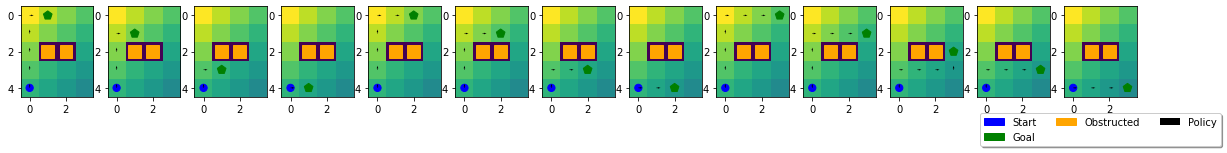

In [80]:
import sys
sys.path.append("..")
import numpy as np
from env.grid_world_multitask import GridWorld
from algorithms.dynamic_programming_multitask import value_iteration
from utils.plots_multitask import plot_gridworld, plot_gridworld_subtasks
import copy

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

###########################################################
#          Run value iteration on a grid world            #
###########################################################

# specify world parameters
num_cols = 4
num_rows = 5
all_states = [ [i, j] for j in range(num_cols) for i in range(num_rows)]
obstructions = [[2,1],[2,2]]
goal_states = np.array([ el for el in all_states if el not in obstructions])
obstructions = np.array(obstructions)
start_states_plot = goal_states[4:5]
goal_states_plot = goal_states[5:]

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=goal_states,
               goal_states=goal_states)
gw.add_obstructions(
                    obstructed_states=obstructions,
                    # bad_states=bad_states,
                    # restart_states=restart_states
                    )
gw.add_rewards(
               step_reward=0,
               goal_reward=1,
               bad_state_reward=0,
               restart_state_reward=0)
gw.add_transition_probability(p_good_transition=1.,
                              bias=0.)
gw.add_discount(discount=0.9)
model = gw.create_gridworld()


# solve with value iteration
value_function, policy = value_iteration(model, maxiter=100)


# plot the results
path = "../doc/imgs/value_iteration.png"
plot_gridworld(model, value_function=value_function, policy=policy,
               # title="Value iteration",
               path=path,
               start_states=start_states_plot, goal_states=goal_states_plot)


In [81]:
value_function = value_function[:, :, 0]

In [82]:
value_function.shape

(21, 21)

In [83]:
from utils.helper_functions import row_col_to_seq, seq_to_col_row

In [84]:
X = []
index = []
for state_seq in range(model.num_states-1):
    for goal in goal_states:
        goal = goal[None, :]
        state = seq_to_col_row(state_seq, model.num_cols)
        goal_seq = row_col_to_seq(goal, model.num_cols)
        x = np.hstack([state, goal])
        X.append(x)
        index.append([state_seq, goal_seq[0]])
X = np.array(X)[:, 0]
index = np.array(index)

y = value_function[index[:, 0], index[:, 1]]

X.shape, y.shape

((360, 4), (360,))

In [85]:
from sklearn.linear_model import LinearRegression

In [86]:
reg = LinearRegression().fit(X, y)

In [87]:
y_hat = reg.predict(X)

In [88]:
((y_hat-y)**2).mean()

0.0641722197831736

In [89]:
def find_plot_pi_hat(y_hat, model, index):
    pi_hat = np.ones((model.num_states, model.num_states, 1))
    val_hat_ = np.zeros((model.num_states, model.num_states, 1))
    val_hat_[index[:, 0], index[:, 1], 0] = y_hat

    # compute the policy
    for state in range(model.num_states):
        for goal in model.goal_states_seq:
            P = copy.deepcopy(model.P)
            P[goal, :, :] = 0
            P[goal, model.num_states - 1, :] = 1
            pi_hat[state, goal] = np.argmax(np.sum(val_hat_[:, goal, :] * P[state,:,:],0))

    # plot the results
    path = "../doc/imgs/value_iteration.png"
    plot_gridworld(model, value_function=val_hat_, policy=pi_hat,
                   # title="Value iteration",
                   path=path,
                   start_states=start_states_plot, goal_states=goal_states_plot)

/home/ivananokhin/tabular_rl/utils/helper_functions_multitask.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[r, c]])
/home/ivananokhin/tabular_rl/utils/helper_functions.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[r, c]])


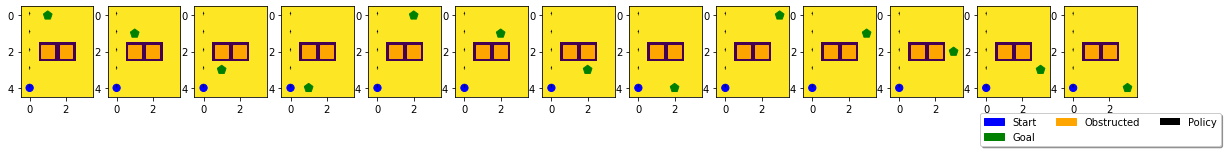

In [90]:
find_plot_pi_hat(y_hat, model, index)

## Simple One-hidden-layer MLP

In [91]:
device='cuda'

In [92]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

In [93]:
class ValueDataset(torch.utils.data.Dataset):
    '''
    Prepare the Boston dataset for regression
    '''

    def __init__(self, X, y, scale_data=False):
        # Apply scaling if necessary
        if scale_data:
            X = StandardScaler().fit_transform(X)
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [94]:
# Prepare dataset
dataset = ValueDataset(X, y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

In [95]:
class MLP(nn.Module):
    def __init__(self, middle_dim=4):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(4, middle_dim),
              nn.LeakyReLU(),
              nn.Linear(middle_dim, 1),
#               nn.LeakyReLU(),
#               nn.Linear(64, 1)
        )


    def forward(self, x):
        return self.layers(x)

In [96]:
# Initialize the MLP
mlp = MLP().to(device)

# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-3)

In [97]:
# Run the training loop
for epoch in range(0, 20000): # 5 epochs at maximum
    # Print epoch
#     print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
    
    if epoch % 500 == 0:
        print('Loss: %.3f' % (current_loss ))
    current_loss = 0.0

# Process is complete.
print('Training process has finished.')

Loss: 11.087
Loss: 2.059
Loss: 1.998
Loss: 1.797
Loss: 1.784
Loss: 1.759
Loss: 1.696
Loss: 1.722
Loss: 1.620
Loss: 1.657
Loss: 1.635
Loss: 1.688
Loss: 1.530
Loss: 1.551
Loss: 1.725
Loss: 1.582
Loss: 1.540
Loss: 1.543
Loss: 1.538
Loss: 1.590
Loss: 1.665
Loss: 1.525
Loss: 1.600
Loss: 1.631
Loss: 1.171
Loss: 1.248
Loss: 1.197
Loss: 1.194
Loss: 1.115
Loss: 1.178
Loss: 1.139
Loss: 1.190
Loss: 1.125
Loss: 1.264
Loss: 1.254
Loss: 1.253
Loss: 1.196
Loss: 1.195
Loss: 1.202
Loss: 1.125
Training process has finished.


In [98]:
# predict = mlp(torch.tensor(StandardScaler().fit_transform(X)).float())[:, 0].detach().numpy()
predict = mlp(torch.tensor(X).float().to(device))[:, 0].detach().cpu().numpy()
((y - predict)**2).mean()

0.06326276862365601

goal_reached 5
goal_reached 4
goal_reached 2
goal_reached 1
goal_reached 6
goal_reached 5
goal_reached 3
goal_reached 2
goal_reached 7
goal_reached 6
goal_reached 5
goal_reached 4
goal_reached 3


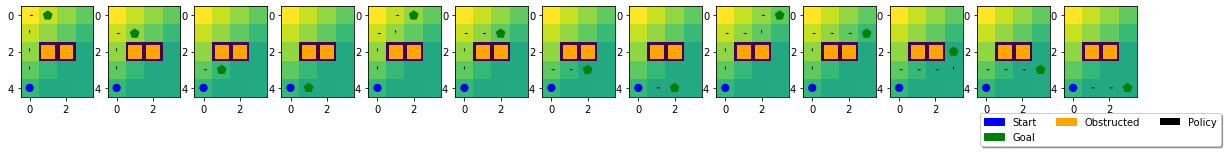

In [99]:
find_plot_pi_hat(predict, model, index)

goal_reached 5
goal_reached 4
goal_reached 2
goal_reached 1
goal_reached 6
goal_reached 5
goal_reached 3
goal_reached 2
goal_reached 7
goal_reached 6
goal_reached 5
goal_reached 4
goal_reached 3


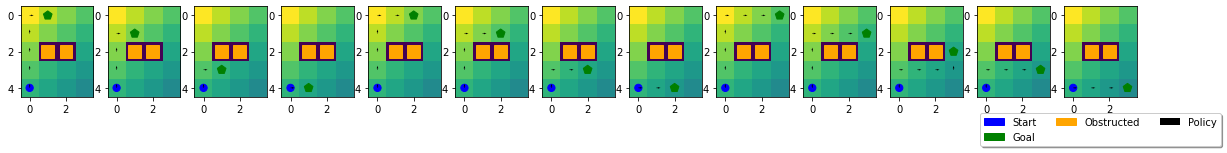

In [100]:
find_plot_pi_hat(y, model, index)

# Devide and Conquer  2

# Devide

In [101]:
# mean, std = 0., 1.
mean, std = np.mean(goal_states, axis=0), np.std(goal_states, axis=0)

In [102]:
class ValueDataset(torch.utils.data.Dataset):
    def __init__(self, value_function, start_states, goal_states, model, mean=None, std=None):
        self.value_function = value_function
        self.start_states = start_states
        self.goal_states = goal_states
        self.start_states_seq = row_col_to_seq(self.start_states, model.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, model.num_cols)
        self.start_states = (self.start_states - mean) / std
        self.goal_states = (self.goal_states - mean) / std
        self.start_dict = {k: v for k, v in zip(self.start_states_seq, self.start_states)}
        self.goal_dict = {k: v for k, v in zip(self.goal_states_seq, self.goal_states)}
        
    def __len__(self):
        return len(self.start_states_seq)*len(self.goal_states_seq)

    def __getitem__(self, idx):
        s_idx = idx % len(self.goal_states_seq) #start index
        g_idx = idx // len(self.goal_states_seq) #goal index
        s = self.start_states_seq[s_idx]
        g = self.goal_states_seq[g_idx]
        if s==g:
            g = self.goal_states_seq[np.random.randint(len(self.goal_states_seq)) % len(self.goal_states_seq)]
        v_x = self.value_function[s, g]
        x = np.hstack([self.start_dict[s], self.goal_dict[g]])
        xsm = []
        xmg = []
        v_xsm = []
        v_xmg = []
        for m in self.start_states_seq:
            xsm.append(np.hstack([self.start_dict[s], self.goal_dict[m]]))
            xmg.append(np.hstack([self.start_dict[m], self.goal_dict[g]]))
            v_xsm.append(self.value_function[s, m])
            v_xmg.append(self.value_function[m, g])

        xsm = np.array(xsm)
        xmg = np.array(xmg)
        v_xsm = np.array(v_xsm)
        v_xmg = np.array(v_xmg)
        return x, xsm, xmg, v_x, v_xsm, v_xmg 

In [103]:
# Prepare dataset
dataset = ValueDataset(value_function,
                       start_states=goal_states, goal_states=goal_states,
                       model=model, 
                       mean=mean, std=std
                      )
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

In [105]:
class DC(nn.Module):
    def __init__(self, middle_dim=4, n_states=7, states=None, mean=0, std=1, device='cuda'):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(4, middle_dim),
              nn.LeakyReLU(),
              nn.Linear(middle_dim, 1),
#               nn.LeakyReLU(),
#               nn.Linear(64, 1)
        )
        
        middle_proba_dim = 16
        self.proba = nn.Sequential(
            nn.Linear(4, middle_proba_dim),
            nn.LeakyReLU(),
#             nn.Linear(middle_proba_dim, middle_proba_dim),
#             nn.LeakyReLU(),
            nn.Linear(middle_proba_dim, n_states+1),
            nn.Softmax()
        )
        
        self.states_original = states
        self.mean = mean
        self.std = std
        self.states = (self.states_original - mean) / std
        
    def prepare_data(self, s, g):
        x = np.hstack([s, g])
        x_s_m = []
        x_m_g = []
        for m in self.states:
            xsm = np.hstack([s, m])
            xmg = np.hstack([m, g])
            x_s_m.append(xsm)
            x_m_g.append(xmg)
        
        x_s_m = np.array(x_s_m)
        x_m_g = np.array(x_m_g)
        
        data = torch.tensor(x[None]).float().to(device), \
        torch.tensor(x_s_m[None]).float().to(device), torch.tensor(x_m_g[None]).float().to(device)
        
        return data
        

    def forward(self, data):
        x, x_s_m, x_m_g = data
        p = self.proba(x)
        y_x = self.layers(x)
        y_xsm = self.layers(x_s_m)
        y_xmg = self.layers(x_m_g)
        subpaths = y_xsm[:, :, 0]*y_xmg[:, :, 0]
        paths = torch.cat([y_x, subpaths], 1)
        return p, paths, y_x, y_xsm, y_xmg


In [108]:
# Initialize the MLP
mlp = DC(states=goal_states, 
         mean=mean, std=std,
         n_states=len(goal_states),
         device=device,
        ).to(device)

# Define the loss function and optimizer
# loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-3)

In [116]:
# Run the training loop
for epoch in range(0, 10000): # 5 epochs at maximum
    # Print epoch
#     print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
        # Get and prepare inputs
        x, x_s_m, x_m_g, v_x, v_xsm, v_xmg  = data
        
        x, x_s_m, x_m_g, v_x, v_xsm, v_xmg  = x.float().to(device), x_s_m.float().to(device), \
        x_m_g.float().to(device), v_x.float().to(device), v_xsm.float().to(device), v_xmg.float().to(device)
        inputs = x, x_s_m, x_m_g
        v_x, v_xsm, v_xmg = v_x.unsqueeze(-1), v_xsm.unsqueeze(-1), v_xmg.unsqueeze(-1)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        p, outputs, y_x, y_xsm, y_xmg = mlp(inputs)

        # Compute loss
        loss_v_x = torch.abs(y_x-v_x)
        loss_v_xsm = torch.abs((y_xsm-v_xsm)*v_xmg)
        loss_v_xmg = torch.abs((y_xmg-v_xmg)*v_xsm)
        loss_vsg_vsmg = torch.abs(v_xsm*v_xmg-v_x.unsqueeze(-1))
        loss_subgoal = loss_v_xsm + loss_v_xmg + loss_vsg_vsmg
        loss_p = (p*torch.log(p)).sum(1).mean()
        loss_subgoal = torch.cat([loss_v_x, loss_subgoal[:, :, 0]], 1)
        loss = (p*loss_subgoal).sum(1).mean(0) + loss_p
        

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
    
    if epoch % 500 == 0:
        print('Loss: %.3f' % (current_loss ))
        print('p argrmax', p.argmax(-1))
        
    current_loss = 0.0

# Process is complete.
print('Training process has finished.')

Loss: -30.241
p argrmax tensor([0, 2, 0, 0], device='cuda:0')
Loss: -30.246
p argrmax tensor([2, 0, 0, 5], device='cuda:0')
Loss: -30.296
p argrmax tensor([ 0,  0, 12,  0], device='cuda:0')
Loss: -30.244
p argrmax tensor([ 0, 16,  0,  2], device='cuda:0')
Loss: -30.197
p argrmax tensor([ 5,  5, 16,  0], device='cuda:0')
Loss: -30.228
p argrmax tensor([16,  3,  4, 18], device='cuda:0')


KeyboardInterrupt: 

In [117]:
predict = []
for x in X:
    s = (x[:2] - mean) / std
    g = (x[2:] - mean) / std
    data = mlp.prepare_data(s, g)
    p, v, y_x, y_xsm, y_xmg = mlp(data)
    idx = p.argmax()
    predict.append(v.detach().cpu().numpy()[:, 0])

predict = np.array(predict)[:, 0]
    
    

In [128]:
goal_states[8:9]

array([[4, 1]])

In [139]:
start_states_plot = goal_states[2:3] #goal_states[8:9]
goal_states_plot = goal_states #goal_states[:6]

start_state_sub = np.tile(start_states_plot, (len(goal_states_plot), 1))
goal_states_sub = goal_states_plot
subgoal_states_sub = []


for s, g in zip(start_state_sub, goal_states_sub):
    s = (s - mean) / std
    g = (g - mean) / std
    data = mlp.prepare_data(s, g)
    p, *_ = mlp(data)
    idx = p.argmax()
    print('idx', idx)
    if idx == 0:
        subgoal_states_sub.append([None])
    else:
        subgoal_states_sub.append(mlp.states_original[idx-1:idx])
        
print(start_state_sub.shape, goal_states_sub.shape, len(subgoal_states_sub))


idx tensor(0, device='cuda:0')
idx tensor(0, device='cuda:0')
idx tensor(3, device='cuda:0')
idx tensor(4, device='cuda:0')
idx tensor(5, device='cuda:0')
idx tensor(0, device='cuda:0')
idx tensor(0, device='cuda:0')
idx tensor(5, device='cuda:0')
idx tensor(0, device='cuda:0')
idx tensor(0, device='cuda:0')
idx tensor(2, device='cuda:0')
idx tensor(0, device='cuda:0')
idx tensor(0, device='cuda:0')
idx tensor(2, device='cuda:0')
idx tensor(2, device='cuda:0')
idx tensor(17, device='cuda:0')
idx tensor(0, device='cuda:0')
idx tensor(0, device='cuda:0')
(18, 2) (18, 2) 18


In [140]:
subgoal_states_sub

[[None],
 [None],
 array([[2, 0]]),
 array([[3, 0]]),
 array([[4, 0]]),
 [None],
 [None],
 array([[4, 0]]),
 [None],
 [None],
 array([[1, 0]]),
 [None],
 [None],
 array([[1, 0]]),
 array([[1, 0]]),
 array([[3, 3]]),
 [None],
 [None]]

In [141]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,20)

In [142]:
def find_plot_pi_hat(y_hat, model, index):
    pi_hat = np.ones((model.num_states, model.num_states, 1))
    val_hat_ = np.zeros((model.num_states, model.num_states, 1))
    val_hat_[index[:, 0], index[:, 1], 0] = y_hat

    # compute the policy
    for state in range(model.num_states):
        for goal in model.goal_states_seq:
            P = copy.deepcopy(model.P)
            P[goal, :, :] = 0
            P[goal, model.num_states - 1, :] = 1
            pi_hat[state, goal] = np.argmax(np.sum(val_hat_[:, goal, :] * P[state,:,:],0))
    
    return pi_hat

goal_reached 2
goal_reached 1
goal_reached 2
goal_reached 2
goal_reached 1
goal_reached 2
goal_reached 2
goal_reached 2
goal_reached 3
goal_reached 2
goal_reached 2
goal_reached 2
goal_reached 3
goal_reached 4
goal_reached 1
goal_reached 2
goal_reached 3
goal_reached 4
goal_reached 1
goal_reached 4
goal_reached 1
goal_reached 3
goal_reached 4
goal_reached 1
goal_reached 4
goal_reached 5


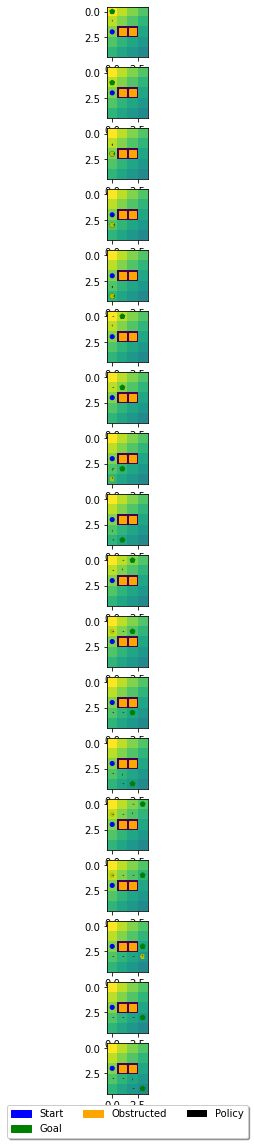

In [143]:
pi_hat = find_plot_pi_hat(predict, model, index)
plot_gridworld_subtasks(model, value_function=value_function, policy=pi_hat, path=path,
                       start_states=start_state_sub, goal_states=goal_states_sub, subgoal_states=subgoal_states_sub)